# Understanding Decision Trees: How Impurity and Pruning Shape Model Performance (Penguins Dataset)

This notebook contains the complete code used for my tutorial:

**"Understanding Decision Trees: How Impurity and Pruning Shape Model Performance (with the Penguins Dataset)"**

The goals of this notebook are:

- To implement a Decision Tree classifier using scikit-learn.
- To compare two impurity measures: **Gini** vs **Entropy**.
- To demonstrate **overfitting** and **pruning** (max depth and cost-complexity pruning).
- To generate all the figures used in the tutorial PDF.
- To reflect briefly on **ethical AI** and **interpretability**.

Personally, what helped me understand Decision Trees was visualising how each split is just a simple question like:

> "Is flipper length less than this value?"

Seeing those questions turn into a tree of decisions made the algorithm feel much less abstract and more like how humans actually reason about problems.

In [11]:
# --- Imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


# --- Reproducibility ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# --- Create a folder for saving figures ---
os.makedirs("figures", exist_ok=True)

print("Setup complete. Ready to load dataset.")

In [12]:
# Load the Palmer Penguins dataset from the official GitHub source
url = "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv"

penguins = pd.read_csv(url)

print("Dataset loaded successfully.")
penguins.head()

Dataset loaded successfully.


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


## Data Preparation

In this section, I clean the Palmer Penguins dataset and select the numerical features that will be used for training the Decision Tree classifier.  
Missing values are removed, and only key measurement variables are kept to simplify the modelling process.

In [13]:
# Select columns of interest
cols_of_interest = [
    "species",
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
]

# Keep only those columns and drop rows with missing values
penguins_clean = penguins[cols_of_interest].dropna().reset_index(drop=True)

print("Dataset shape after dropping missing values:", penguins_clean.shape)
penguins_clean.head()

Dataset shape after dropping missing values: (342, 5)


,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
3,Adelie,36.7,19.3,193.0,3450.0
4,Adelie,39.3,20.6,190.0,3650.0


In [14]:
# Features (X) and target (y)
X = penguins_clean[
    ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
].values

y_labels = penguins_clean["species"].values

# Encode species labels as integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)

print("Classes:", label_encoder.classes_)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Classes: ['Adelie' 'Chinstrap' 'Gentoo']
Train shape: (273, 4)  Test shape: (69, 4)


## Exploratory Visualisation

Before training the Decision Tree classifier, it is helpful to look at how the penguin species differ in their physical measurements.  
A simple scatter plot can reveal patterns in flipper length and body mass, giving intuition about how the tree might separate the classes.

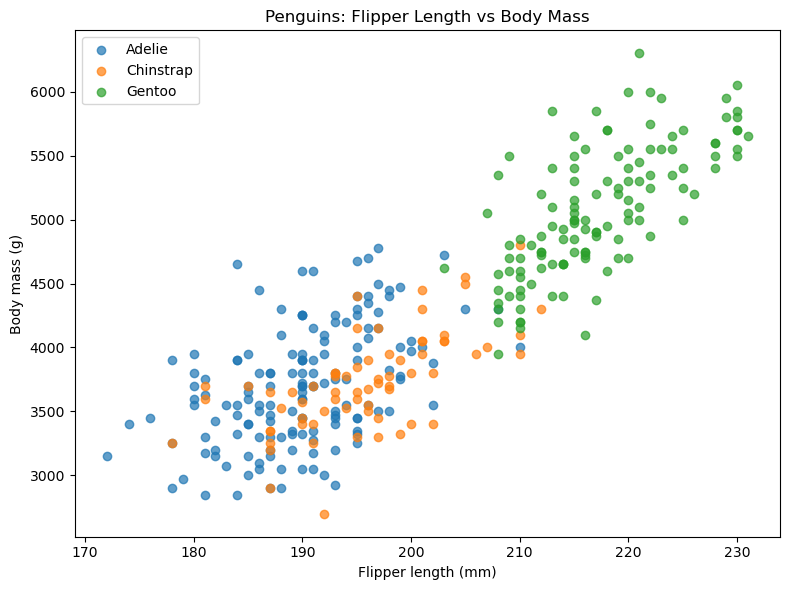

In [15]:
plt.figure(figsize=(8, 6))

for class_index, class_name in enumerate(label_encoder.classes_):
    mask = y == class_index
    plt.scatter(
        penguins_clean.loc[mask, "flipper_length_mm"],
        penguins_clean.loc[mask, "body_mass_g"],
        label=class_name,
        alpha=0.7,
    )

plt.xlabel("Flipper length (mm)")
plt.ylabel("Body mass (g)")
plt.title("Penguins: Flipper Length vs Body Mass")
plt.legend()
plt.tight_layout()

# Save figure for the PDF tutorial
plt.savefig("figures/penguins_scatter_flipper_bodymass.png", dpi=300)

plt.show()


## Baseline Decision Tree using Gini Impurity

Next, I train a baseline Decision Tree classifier using the default **Gini** impurity measure.  
This gives a first idea of how well a single tree can separate the penguin species using only the four numerical measurements.
I also check the depth of the tree and the number of leaves, which will be useful later when discussing overfitting and pruning.

In [16]:
# Train a baseline Decision Tree using Gini impurity
gini_tree = DecisionTreeClassifier(
    criterion="gini",
    random_state=RANDOM_STATE
)

gini_tree.fit(X_train, y_train)

# Predictions
y_train_pred_gini = gini_tree.predict(X_train)
y_test_pred_gini = gini_tree.predict(X_test)

# Accuracy scores
print("Gini Tree - Train Accuracy:", accuracy_score(y_train, y_train_pred_gini))
print("Gini Tree - Test Accuracy :", accuracy_score(y_test, y_test_pred_gini))

# Tree structure info
print("Tree Depth:", gini_tree.get_depth())
print("Number of Leaves:", gini_tree.get_n_leaves())


Gini Tree - Train Accuracy: 1.0
Gini Tree - Test Accuracy : 1.0
Tree Depth: 7
Number of Leaves: 14


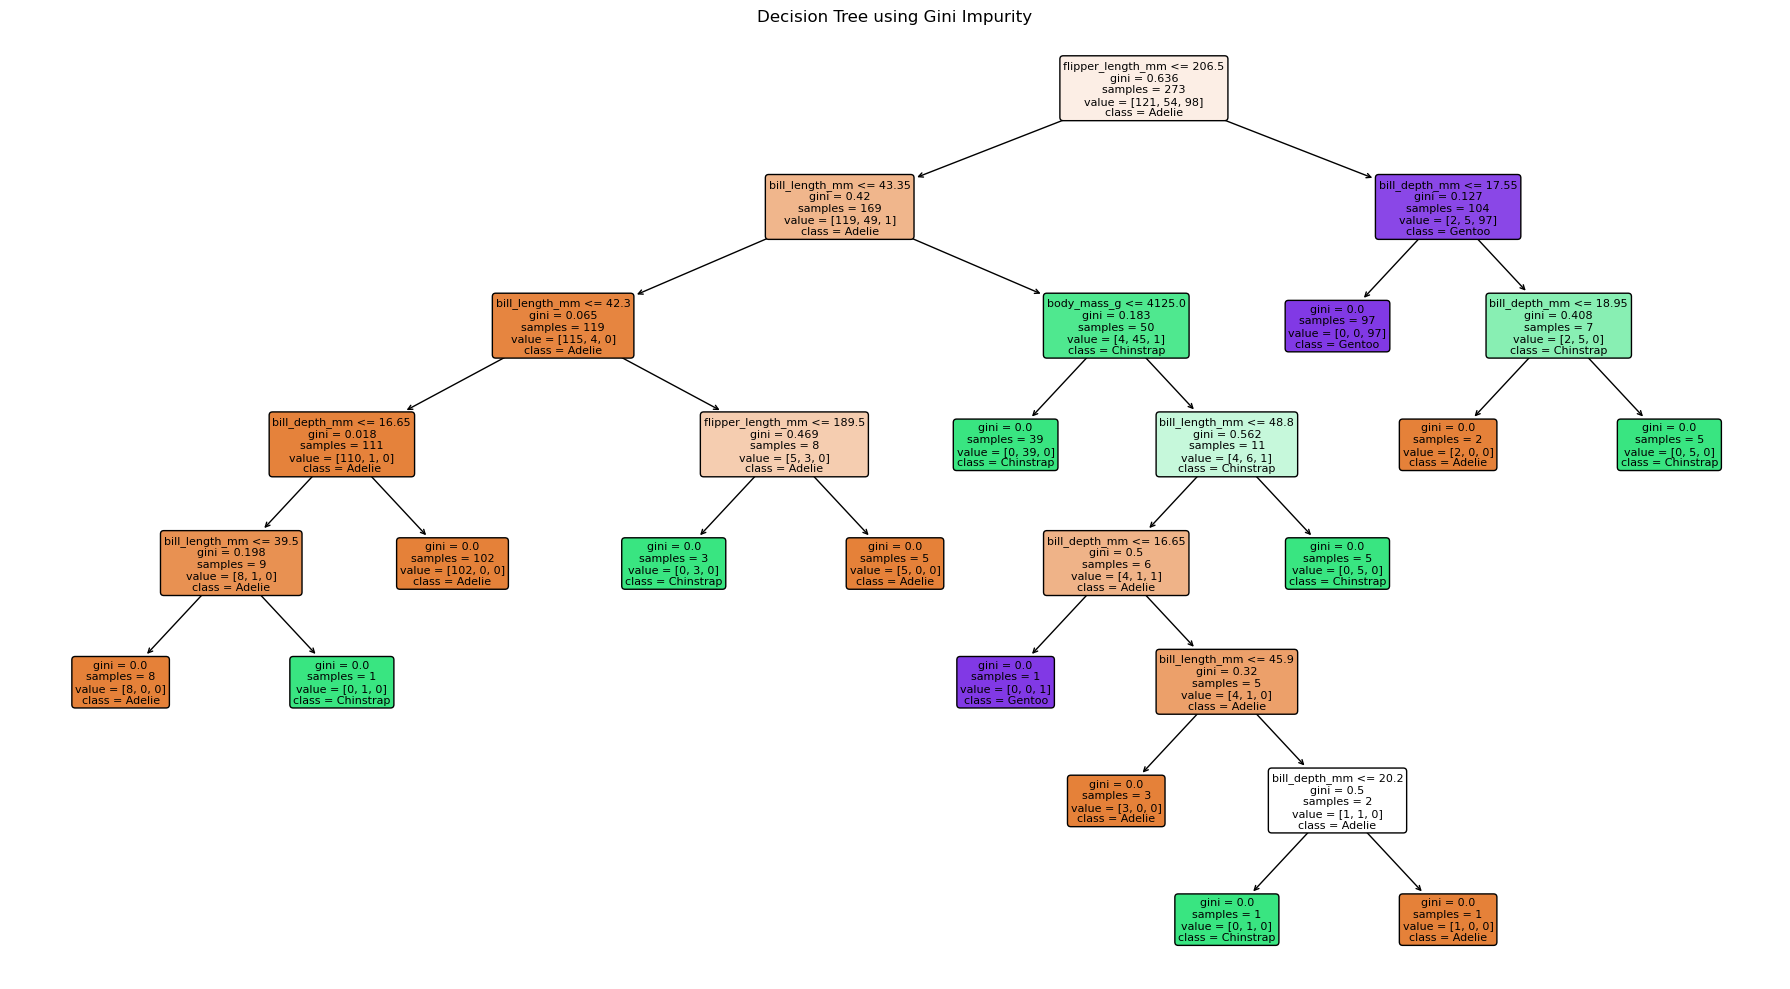

In [18]:
plt.figure(figsize=(18, 10))

plot_tree(
    gini_tree,
    feature_names=[
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g"
    ],
    class_names=list(label_encoder.classes_),   # FIXED
    filled=True,
    rounded=True,
    fontsize=8
)

plt.title("Decision Tree using Gini Impurity")
plt.tight_layout()

plt.savefig("figures/gini_tree_full.png", dpi=300)
plt.show()

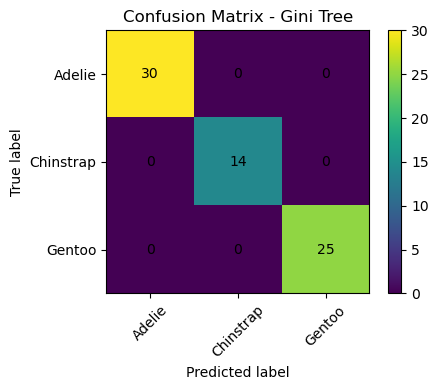

Classification report (Gini Tree):
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



In [19]:
# Confusion matrix for the Gini-based Decision Tree
cm_gini = confusion_matrix(y_test, y_test_pred_gini)

plt.figure(figsize=(5, 4))
plt.imshow(cm_gini, interpolation="nearest")
plt.title("Confusion Matrix - Gini Tree")
plt.colorbar()

tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)

# Add counts on top of the heatmap
for i in range(cm_gini.shape[0]):
    for j in range(cm_gini.shape[1]):
        plt.text(j, i, cm_gini[i, j], ha="center", va="center")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.savefig("figures/gini_confusion_matrix.png", dpi=300)
plt.show()

# Textual evaluation
print("Classification report (Gini Tree):")
print(classification_report(y_test, y_test_pred_gini, target_names=list(label_encoder.classes_)))


## Comparing Gini vs Entropy

Decision Trees can use different impurity measures to decide how to split the data.  
The two most common criteria are **Gini impurity** (the default in scikit-learn) and **Entropy** (based on information gain).

In this section, I train two trees with identical settings except for the `criterion` parameter:

- one using **Gini**
- one using **Entropy**

Then I compare their accuracy, depth, and number of leaves.  
This helps illustrate how impurity measures can slightly change the structure and behaviour of a Decision Tree.


In [20]:
criteria = ["gini", "entropy"]
results = {}
rows = []

for crit in criteria:
    clf = DecisionTreeClassifier(
        criterion=crit,
        random_state=RANDOM_STATE
    )
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    depth = clf.get_depth()
    n_leaves = clf.get_n_leaves()

    # Store model for later plots if needed
    results[crit] = {
        "model": clf,
        "y_train_pred": y_train_pred,
        "y_test_pred": y_test_pred,
    }

    rows.append(
        {
            "criterion": crit,
            "train_accuracy": train_acc,
            "test_accuracy": test_acc,
            "depth": depth,
            "n_leaves": n_leaves,
        }
    )

results_df = pd.DataFrame(rows)
results_df


,criterion,train_accuracy,test_accuracy,depth,n_leaves
0,gini,1.0,1.000000,7,14
1,entropy,1.0,0.985507,6,12


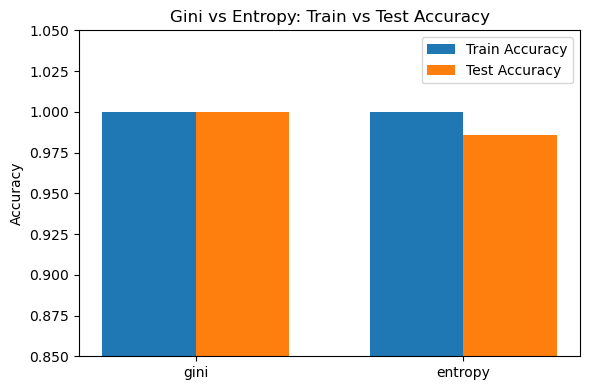

In [21]:
# Plot Train vs Test Accuracy for Gini and Entropy
plt.figure(figsize=(6, 4))

x = np.arange(len(results_df["criterion"]))
width = 0.35

train_accs = results_df["train_accuracy"].values
test_accs = results_df["test_accuracy"].values

plt.bar(x - width/2, train_accs, width, label="Train Accuracy")
plt.bar(x + width/2, test_accs, width, label="Test Accuracy")

plt.xticks(x, results_df["criterion"])
plt.ylabel("Accuracy")
plt.ylim(0.85, 1.05)
plt.title("Gini vs Entropy: Train vs Test Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("figures/gini_vs_entropy_accuracy.png", dpi=300)
plt.show()


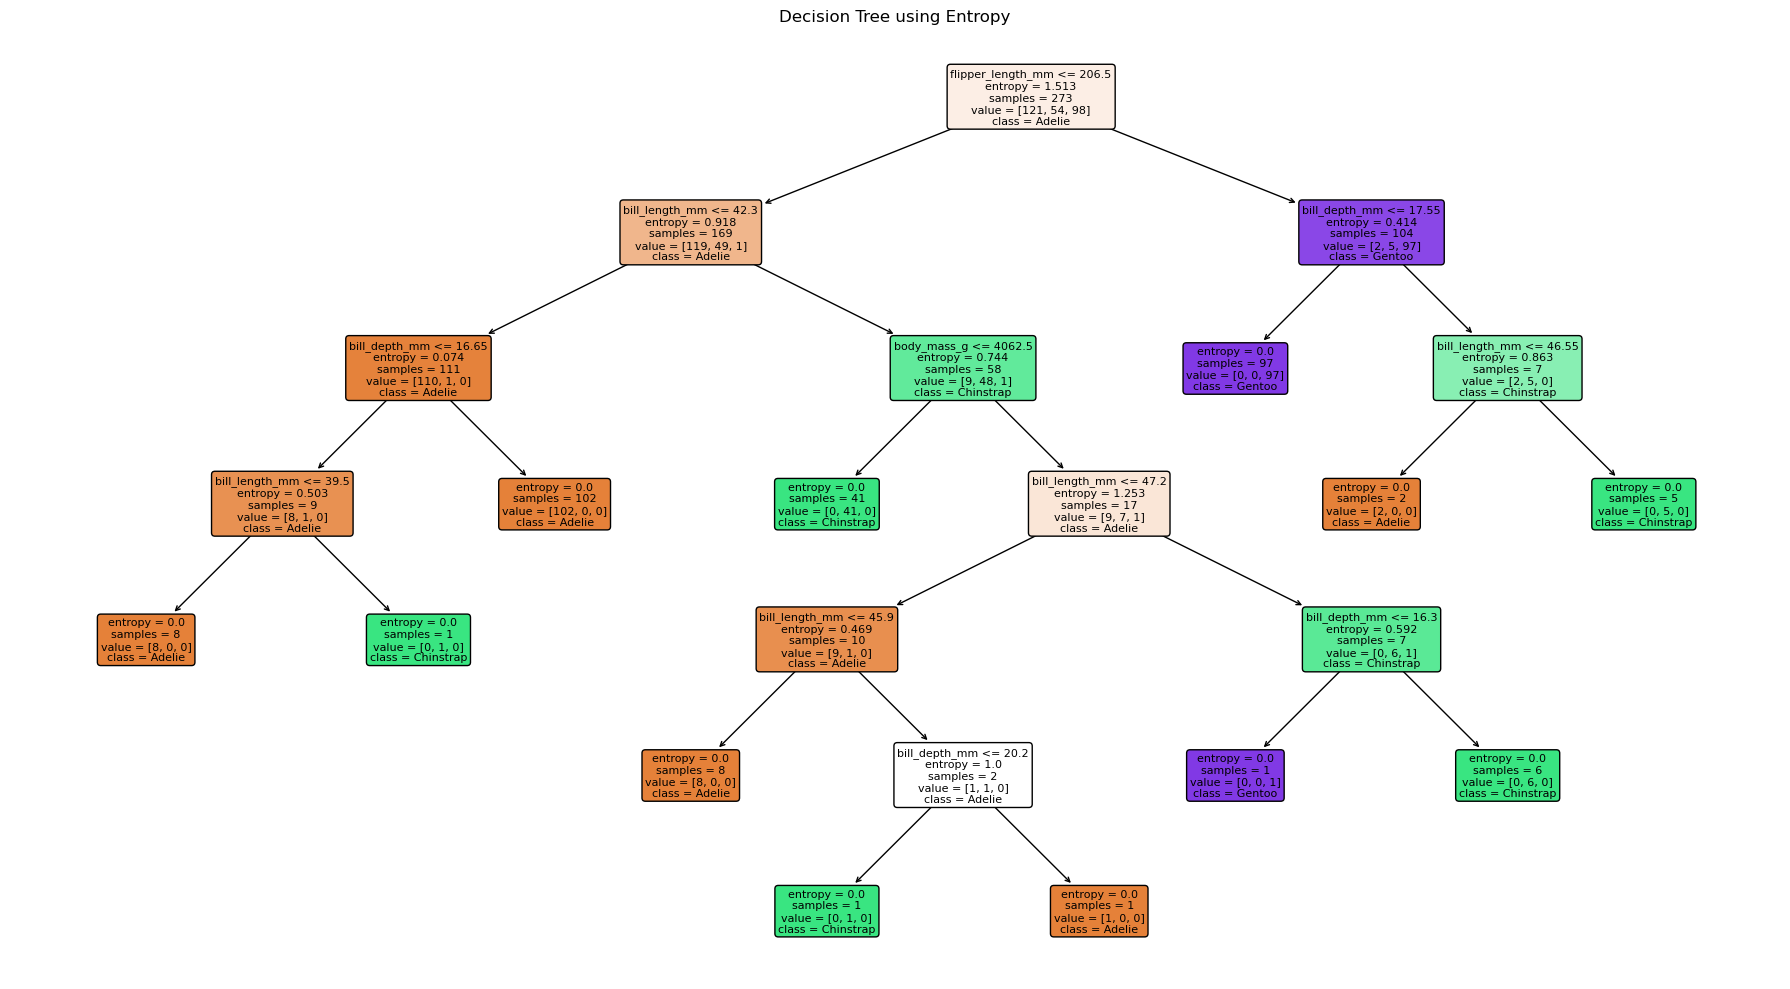

In [22]:
# Retrieve the entropy-based model from the results dictionary
entropy_tree = results["entropy"]["model"]

plt.figure(figsize=(18, 10))

plot_tree(
    entropy_tree,
    feature_names=[
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g"
    ],
    class_names=list(label_encoder.classes_),
    filled=True,
    rounded=True,
    fontsize=8
)

plt.title("Decision Tree using Entropy")
plt.tight_layout()
plt.savefig("figures/entropy_tree_full.png", dpi=300)
plt.show()


## Overfitting and the Effect of Tree Depth

Decision Trees can easily overfit the training data if they are allowed to grow too deep.  
To see this, I train several trees with different `max_depth` values and compare the training and test accuracy.

If the depth is too small, the tree underfits (high bias).  
If the depth is too large, the tree may overfit (high variance).

In the next cell, I loop over several depths and record the performance.


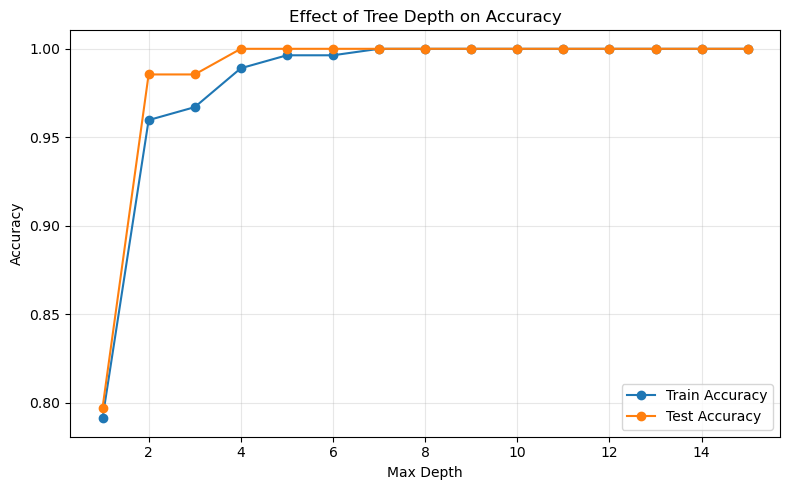

In [23]:
depths = range(1, 16)  # Try depths from 1 to 15
train_acc_list = []
test_acc_list = []

for d in depths:
    clf = DecisionTreeClassifier(
        criterion="gini",
        max_depth=d,
        random_state=RANDOM_STATE
    )
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc_list.append(accuracy_score(y_train, y_train_pred))
    test_acc_list.append(accuracy_score(y_test, y_test_pred))

# Plotting the accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(depths, train_acc_list, marker='o', label="Train Accuracy")
plt.plot(depths, test_acc_list, marker='o', label="Test Accuracy")

plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Effect of Tree Depth on Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/depth_vs_accuracy.png", dpi=300)
plt.show()


## Cost-Complexity Pruning (ccp_alpha)

The previous plot shows that deeper trees can overfit the training data.  
Scikit-learn implements **cost-complexity pruning**, which trims back branches that do not improve performance enough.

The idea is to control a parameter called `ccp_alpha`:

- When `ccp_alpha = 0`, the tree is fully grown.
- As `ccp_alpha` increases, more branches are pruned and the tree becomes smaller.

In the next cells, I:
1. Compute the pruning path for the fully grown tree.
2. Train a sequence of pruned trees for different `ccp_alpha` values.
3. Plot how accuracy changes with `ccp_alpha`.


In [24]:
# Start from a fully grown tree (no max_depth, no pre-pruning)
base_tree = DecisionTreeClassifier(
    criterion="gini",
    random_state=RANDOM_STATE
)
base_tree.fit(X_train, y_train)

# Get the effective alphas and corresponding total impurities
path = base_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

print("Number of alphas in pruning path:", len(ccp_alphas))

clfs = []
train_acc_ccp = []
test_acc_ccp = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        criterion="gini",
        random_state=RANDOM_STATE,
        ccp_alpha=ccp_alpha
    )
    clf.fit(X_train, y_train)
    clfs.append(clf)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc_ccp.append(accuracy_score(y_train, y_train_pred))
    test_acc_ccp.append(accuracy_score(y_test, y_test_pred))

len(clfs), len(train_acc_ccp), len(test_acc_ccp)


Number of alphas in pruning path: 10


(10, 10, 10)

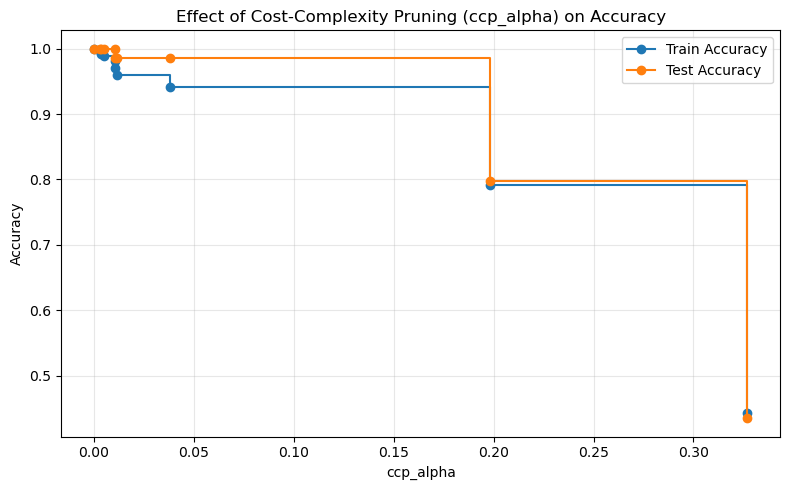

In [25]:
plt.figure(figsize=(8, 5))

plt.plot(ccp_alphas, train_acc_ccp, marker='o', label="Train Accuracy", drawstyle="steps-post")
plt.plot(ccp_alphas, test_acc_ccp, marker='o', label="Test Accuracy", drawstyle="steps-post")

plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Effect of Cost-Complexity Pruning (ccp_alpha) on Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/ccp_alpha_vs_accuracy.png", dpi=300)
plt.show()


## Feature Importance

One of the reasons I like Decision Trees is that they provide a simple way to see which features are most important for the predictions.

Scikit-learn computes a feature importance score based on how much each feature reduces impurity across all splits in the tree.

In the next cell, I use the (unpruned) Gini tree to:

- extract the feature importances, and  
- plot them as a bar chart.

This helps to check whether the model is using features in a way that makes sense (for example, flipper length and bill depth are biologically meaningful for distinguishing penguin species).


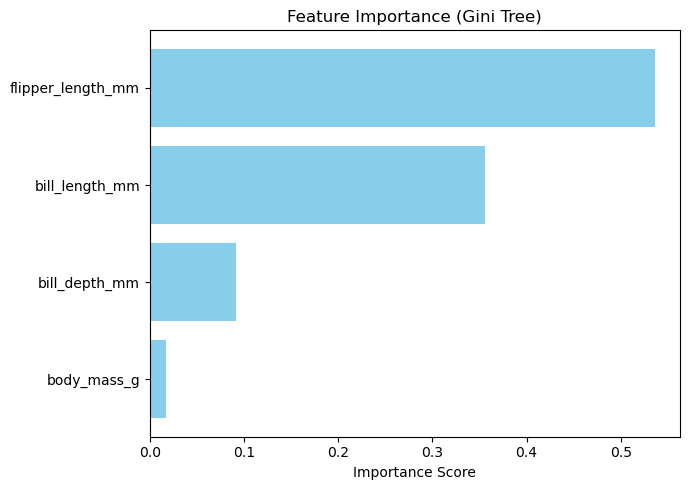

bill_length_mm: 0.3554
bill_depth_mm: 0.0914
flipper_length_mm: 0.5361
body_mass_g: 0.0172


In [26]:
# Feature names in the same order as X
feature_names = [
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "body_mass_g"
]

# Extract feature importances from the Gini tree
importances = gini_tree.feature_importances_

# Sort for nicer plotting
indices = np.argsort(importances)

plt.figure(figsize=(7, 5))
plt.barh(
    [feature_names[i] for i in indices],
    importances[indices],
    color="skyblue"
)

plt.xlabel("Importance Score")
plt.title("Feature Importance (Gini Tree)")
plt.tight_layout()
plt.savefig("figures/feature_importance_gini.png", dpi=300)
plt.show()

# Also print numerical values
for fname, importance in zip(feature_names, importances):
    print(f"{fname}: {importance:.4f}")


## Visualising a Pruned Tree

To make the Decision Tree easier to interpret and less likely to overfit, I can use one of the pruned models from the cost-complexity pruning path.

Here I select the tree with the best test accuracy along the `ccp_alpha` path and plot it.  
This pruned tree is usually:

- smaller than the fully grown tree,  
- slightly less accurate on the training set, but  
- often similar or better on the test set.

It also makes a much clearer visual example to include in the tutorial.

Best ccp_alpha based on test accuracy: 0.0
Corresponding test accuracy: 1.0
Pruned tree depth: 7
Pruned tree leaves: 14


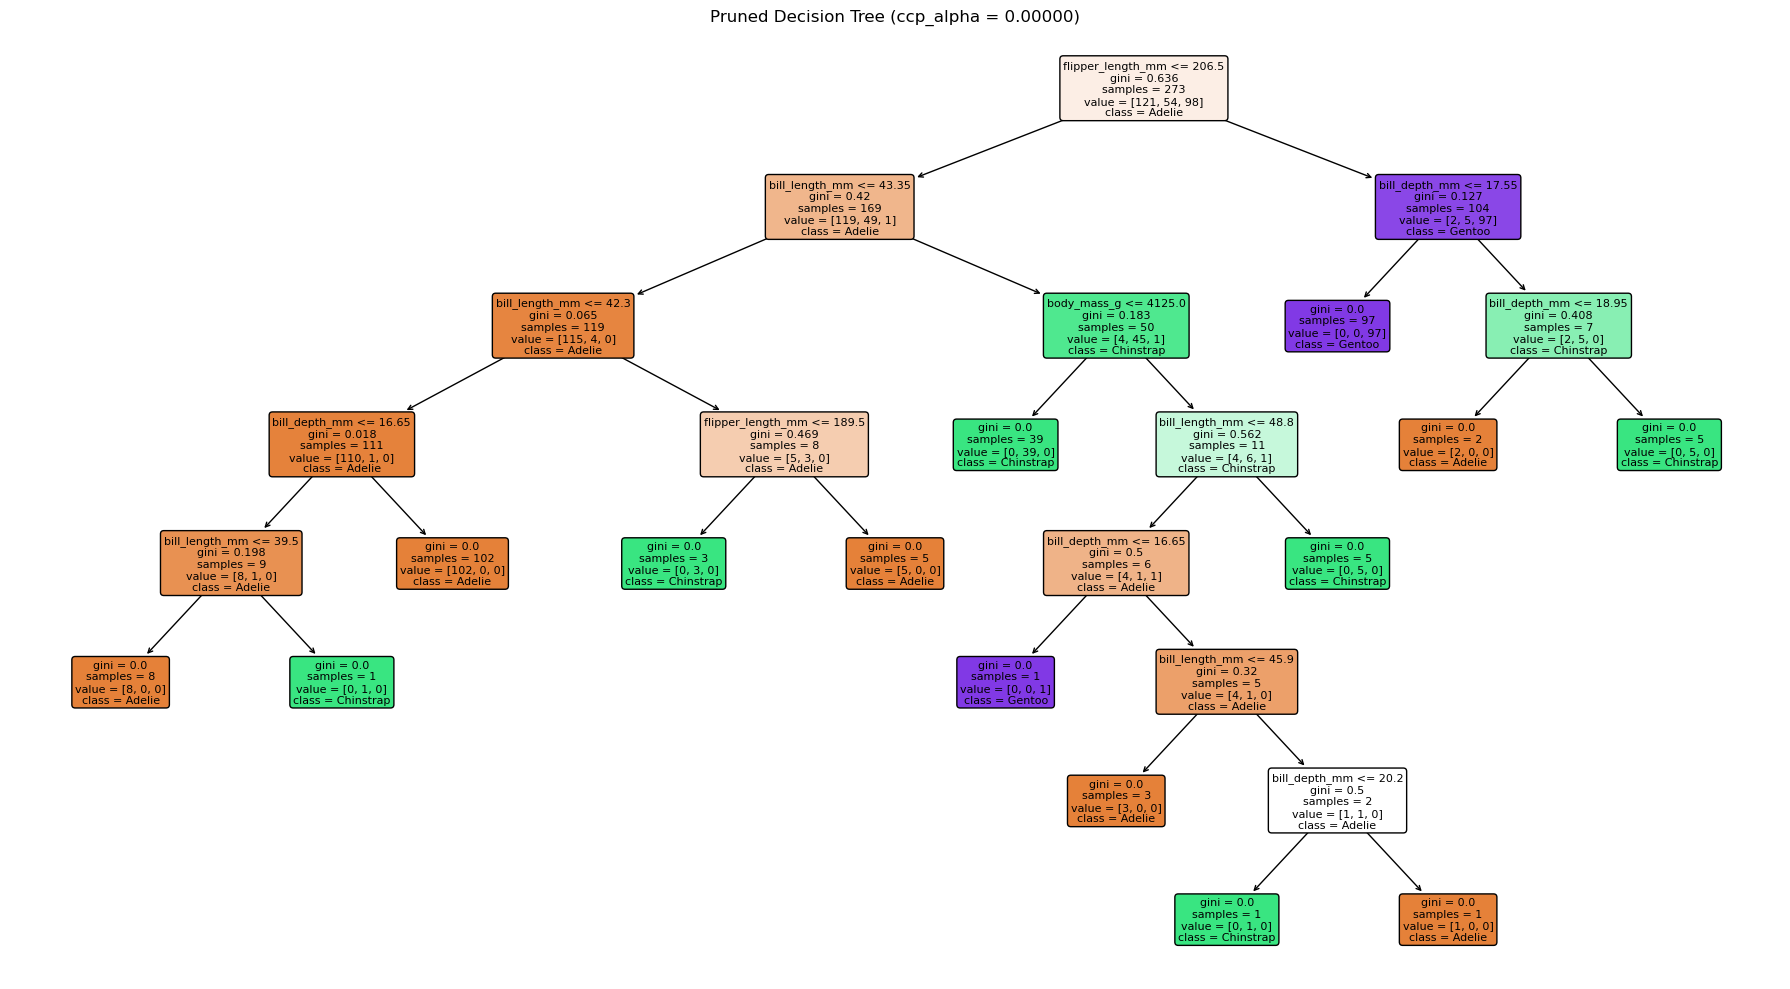

In [27]:
# Find the index of the best test accuracy along the pruning path
best_index = int(np.argmax(test_acc_ccp))
best_alpha = ccp_alphas[best_index]

print("Best ccp_alpha based on test accuracy:", best_alpha)
print("Corresponding test accuracy:", test_acc_ccp[best_index])

# Train a pruned tree using this alpha
pruned_tree = DecisionTreeClassifier(
    criterion="gini",
    random_state=RANDOM_STATE,
    ccp_alpha=best_alpha
)
pruned_tree.fit(X_train, y_train)

print("Pruned tree depth:", pruned_tree.get_depth())
print("Pruned tree leaves:", pruned_tree.get_n_leaves())

# Plot the pruned tree
plt.figure(figsize=(18, 10))

plot_tree(
    pruned_tree,
    feature_names=[
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g"
    ],
    class_names=list(label_encoder.classes_),
    filled=True,
    rounded=True,
    fontsize=8
)

plt.title(f"Pruned Decision Tree (ccp_alpha = {best_alpha:.5f})")
plt.tight_layout()
plt.savefig("figures/pruned_tree.png", dpi=300)
plt.show()


## Conclusion

In this notebook, I explored how Decision Trees behave on the Palmer Penguins dataset, focusing on three main aspects:

1. **Impurity measures (Gini vs Entropy)**  
   I trained two trees with identical settings apart from the `criterion` parameter.  
   Both achieved high accuracy, but the exact tree structure, depth and number of leaves were slightly different.  
   This shows that the choice of impurity measure can subtly change how the tree splits the data, even when performance is similar.

2. **Model complexity, depth and overfitting**  
   By training trees with increasing `max_depth`, I observed the typical pattern where:
   - training accuracy keeps increasing with depth, and
   - test accuracy improves at first, then starts to fall when the model becomes too complex.  
   This is a clear demonstration of the bias–variance trade-off for Decision Trees.

3. **Pruning and interpretability**  
   Using cost-complexity pruning (`ccp_alpha`), I generated a sequence of pruned trees and selected the one with the best test accuracy.  
   The pruned tree was shallower and had fewer leaves than the fully grown tree, while still performing well on the test set.  
   This pruned model is easier to interpret and less likely to overfit.

Personally, the parts that helped my understanding the most were:

- plotting **accuracy vs depth**, because it made the overfitting behaviour visible, and  
- visualising both the **full** and **pruned** trees, which made it clear how pruning cuts away branches that do not add much predictive value.

These experiments connect the theory of impurity and pruning with practical model behaviour, and they also highlight why Decision Trees are a useful starting point for more advanced ensemble methods such as Random Forests and Gradient Boosting.

## References and Useful Resources

Below are the main resources I used to prepare the tutorial and this notebook:

- Breiman, L., Friedman, J. H., Olshen, R. A., & Stone, C. J. (1984). *Classification and Regression Trees*. Wadsworth.  
- Scikit-Learn Documentation – Decision Trees:  
  https://scikit-learn.org/stable/modules/tree.html  
- Scikit-Learn API – `DecisionTreeClassifier`:  
  https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html  
- Palmer Penguins dataset by Allison Horst:  
  https://allisonhorst.github.io/palmerpenguins/  
- Mitchell, T. M. (1997). *Machine Learning*. McGraw-Hill.  
- Géron, A. (2019). *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow* (2nd ed.). O’Reilly Media.

These links are also included in my written PDF tutorial and in the GitHub repository README so that anyone following the tutorial can read further or check the original sources.